## Прогнозирование оттока клиентов

**Цель:** уменьшить отток клиентов для сети фитнес-центров.

**Задачи:**
- научиться (построить мат. модель) прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами.

**Описание:** <br> <p>
Одной из ключевых проблем фитнес-клубов и подобных сервисов является высокий уровень оттока клиентов. В контексте фитнес-центра клиент считается ушедшим, если в течение последнего месяца у него не было ни одного посещения. <br> <p>
Для снижения оттока отдел по работе с клиентами оцифровал большое количество анкет, чтобы глубже изучить поведение клиентов. На основе этих данных требуется провести аналитическое исследование и разработать стратегию по повышению их лояльности и удержанию. 

<a name='Описание-данных'>**Описание данных** <br> </a>
В файле `gym_churn.csv` находится данные на месяц до оттока и факт оттока на определённый месяц. <br> 
Набор данных включает следующие поля:<br><br>

- Данные клиента за предыдущий до проверки факта оттока месяц:
   * 'gender' — пол;
   * 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
   * 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
   * Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
   * 'Phone' — наличие контактного телефона;
   * 'Age' — возраст;
   * 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
   <br> <p>
- Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
    * 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
    * 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
    * 'Group_visits' — факт посещения групповых занятий;
    * 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
    * 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
    * 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
      <br> <p>
- 'Churn' — факт оттока в текущем месяце.


In [1]:
# импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

### Открытие файлов с данными и вывод общей информации

In [2]:
# адреса локальных файлов
files = ['local.csv']

# URLs на файлы
urls = [r'https://code.s3.yandex.net/****.csv']

try: # по возмажности локальный файл
    df = pd.read_csv(files[0])
except: # иначе URL
     df = pd.read_csv(urls[0])
    
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Итого 4000 строк, без пропусков. <br>
Переведем название полей в нижний регистр

In [4]:
# переводим названия полей в нижний регистр
df.columns = df.columns.str.lower()

df.sample(5) # проверка

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
3293,1,1,0,0,1,1,1,31,225.744906,1.0,4,1.562964,1.524219,0
988,1,1,0,1,1,12,1,30,140.986759,10.0,4,2.318274,2.349477,0
3268,1,1,0,0,1,1,0,25,307.812299,1.0,4,0.000000,0.000000,0
542,0,1,1,1,1,12,0,29,174.890044,12.0,10,2.537883,2.551692,0
3856,1,1,1,1,1,6,0,31,104.266648,4.0,15,1.712596,1.730650,0


In [5]:
df[df.duplicated()] # проверка на полные дубликаты

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn


Полных дубликатов не обнаружено

In [6]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [7]:
# проверим, есть ли в поле month_to_end_contract float значения
df.month_to_end_contract.unique()

array([ 5., 12.,  1.,  6.,  3., 10., 11.,  9.,  4.,  7.,  8.,  2.])

In [8]:
# в month_to_end_contract float не обнаружено
# переведем month_to_end_contract в тип int
df.month_to_end_contract = df.month_to_end_contract.astype('int')

df.info() # проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

### Исследовательский анализ данных (EDA)

[Общий анализ параметров](#Открытие-файлов-с-данными-и-вывод-общей-информации):
* Дубликатов и пропусков не обнаружено.
* Параметры gender, near_location, partner, promo_friends, phone, group_visits, churn - бинарные
* Параметры contract_period (1, 6, 12 месяцев), age (от 18 до 41 года), month_to_end_contract (от 1 до 12 месяцев), lifetime (от 1 до 31 месяца) - дискретно-числовые
* Параметры avg_additional_charges_total, avg_class_frequency_total, avg_class_frequency_current_month - агрегированные (непрерывные) 
* среднее отклонение у параметров не равно 0, значит констант нет.
* Для бинарных параметров gender, partner, group_visits среднее значение и стандартное отклонение близки к 0,5, что свидетельствует о их сбалансированности. Однако наблюдается незначительный перекос в распределении, который подтверждается анализом процентного соотношения категорий (mean).

Проанализируем распределение средних значений признаков в разрезе групп: клиенты, ушедшие в отток, и оставшиеся

In [9]:
# проверяем распределение средних значений признаков по группам
df_groups = df.groupby(by='churn')

df_groups.mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


* По gender, phone существенных различий в средних значениях нет
* По near_location, age  умеренное различие средних значений 
* По остальным параметрам - значимое различие средних значений

Построим столбчатые гистограммы и графики распределения признаков

In [10]:
# функция для отрисовки гисторамм и boxplot 
def draw_hist_bp(data, field, fr_size_title=18 , fr_size_main=12):
    """
     Визуализирует распределение признака через гистограммы и boxplot 
     с разделением по целевому признаку "отток".
     --------------
    :param data: DataFrame из которого принимаем данные
    :param field: поле с параметром по которому строятся графики
    :param fr_size_title: размер шрифта заголовков, по умолчанию=18
    :param fr_size_main: размер основного шрифта метки/подписи, по умолчанию=12
    :return: отображает графики sns.histplot/sns.boxplot с разделениями по оттоку
    """
    
    sns.set_style("whitegrid")
    binar_parametr = data[field].nunique()==2 # True если бинарный параметр
    
    if binar_parametr:
        fig, ax = plt.subplots(1, 2, figsize=(15, 5)) # только гистограмма
    else:
        fig, ax = plt.subplots(2, 2, figsize=(15, 10)) # гистограмма и boxplot
        
    ax = ax.ravel() # преобразовываем массив в плоский [0,1,2,3]
    
    # hist
    if binar_parametr:
        sns.histplot(data=data[data['churn']==0], x=field,
                                 ax=ax[0], discrete=True, shrink=0.8)
        sns.histplot(data=data[data['churn']==1], x=field,
                                 ax=ax[1], discrete=True, shrink=0.8)
    else:
        sns.histplot(data=data[data['churn']==0], x=field, ax=ax[0])
        sns.histplot(data=data[data['churn']==1], x=field, ax=ax[1])
    # Настройки графика
    ax[0].set_title(f"Гистограмма {field} оставшиеся")
    ax[1].set_title(f"Гистограмма {field} ушедшие")
    # находим минимальные/максимальное значения по осям
    max_x = max(ax[0].get_xlim()[1], ax[1].get_xlim()[1])
    max_y = max(ax[0].get_ylim()[1], ax[1].get_ylim()[1])
    min_x = min(ax[0].get_xlim()[0], ax[1].get_xlim()[0])
    for axn in ax[:2]:  # настройка меток для графиков 1 строки
        axn.set_ylabel("Количество")
        axn.set_xlabel(field)
        axn.set_xlim(int(min_x), int(max_x))  # устанавливаем одинаковую градацию по Х
        axn.set_ylim(0, int(max_y))  # устанавливаем одинаковую градацию по Y
    
    # boxplot
    if not binar_parametr:
        sns.boxplot(data=data[data['churn']==0], y=field, ax=ax[2])
        sns.boxplot(data=data[data['churn']==1], y=field, ax=ax[3])
        # Настройки графиков
        ax[2].set_title(f"boxplot {field} оставшиеся")
        ax[3].set_title(f"boxplot {field} ушедшие")
        # находим минимальные/максимальное значения по осям
        max_y = max(ax[2].get_ylim()[1], ax[3].get_ylim()[1])
        min_y = min(ax[2].get_ylim()[0], ax[3].get_ylim()[0])
        for axn in ax[2:]:  # настройка меток для графиков 2 строки
            axn.set_ylabel(field)
            axn.set_ylim(int(min_y)*0.9, int(max_y)/0.9)  # устанавливаем одинаковую градацию по Y
    
    # Параметры графиков
    plt.tight_layout()  # избежать наложения подписей
    for ax in ax.ravel():  # работа с каждым графиком отдельно
        ax.tick_params(axis='both', labelsize=fr_size_main) # размер шрифта меток
        ax.title.set_fontsize(fr_size_title) # размер шрифта заголовков
        ax.xaxis.label.set_fontsize(fr_size_main)  # размер шрифта оси X
        ax.yaxis.label.set_fontsize(fr_size_main) # размер шрифта оси Y
    
    plt.show()

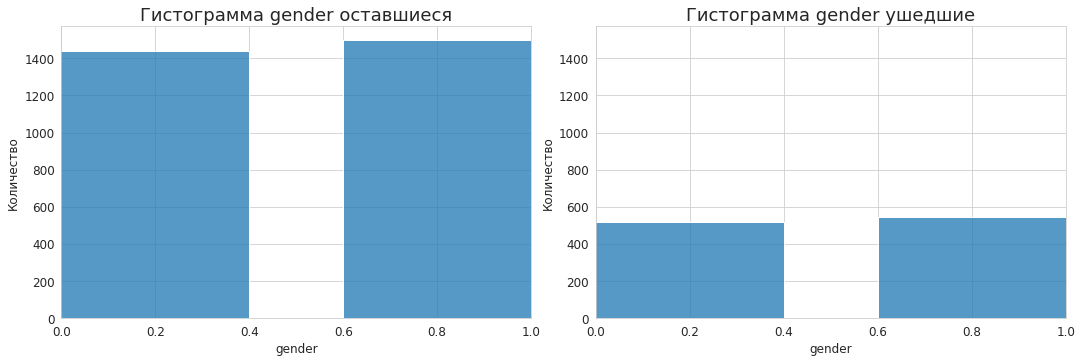

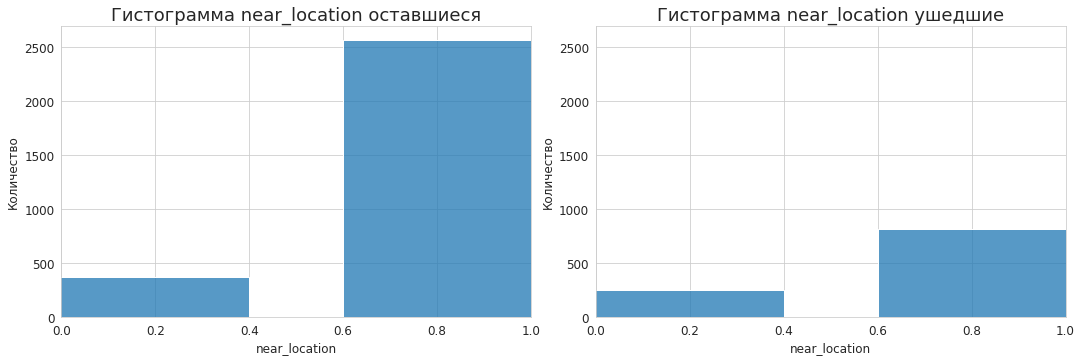

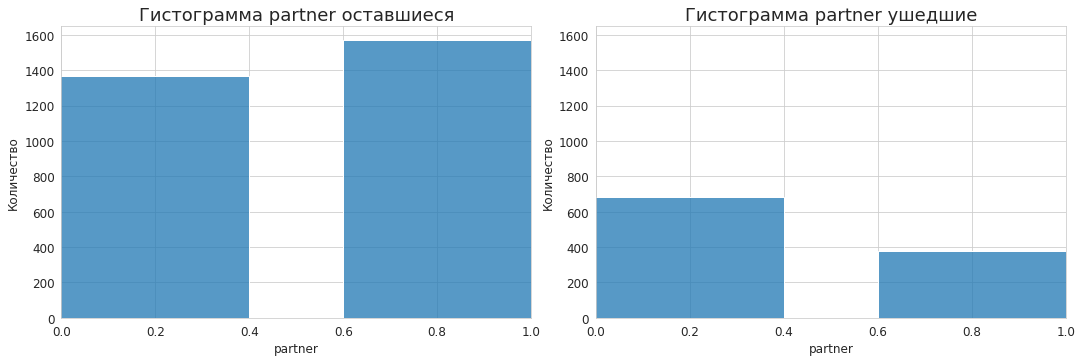

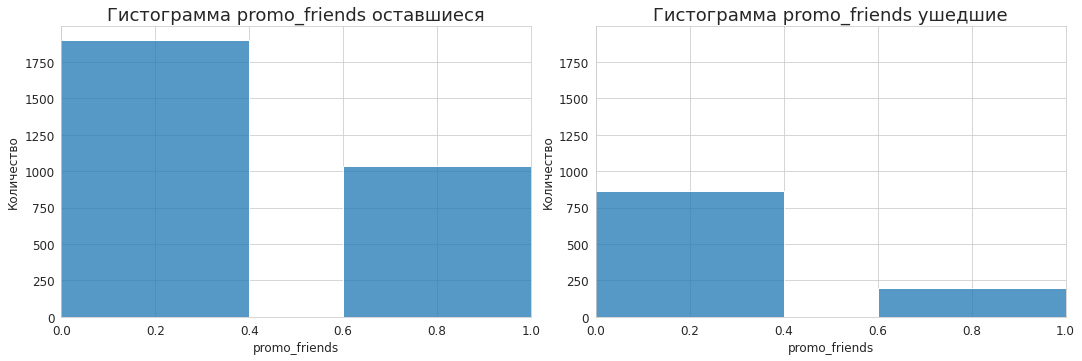

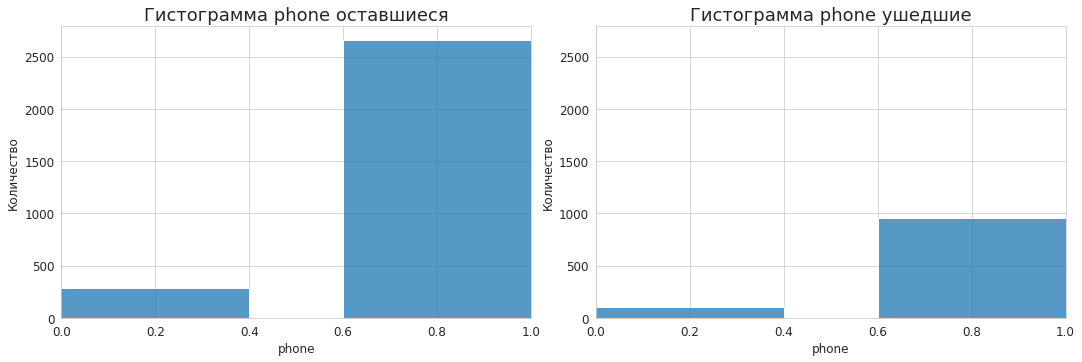

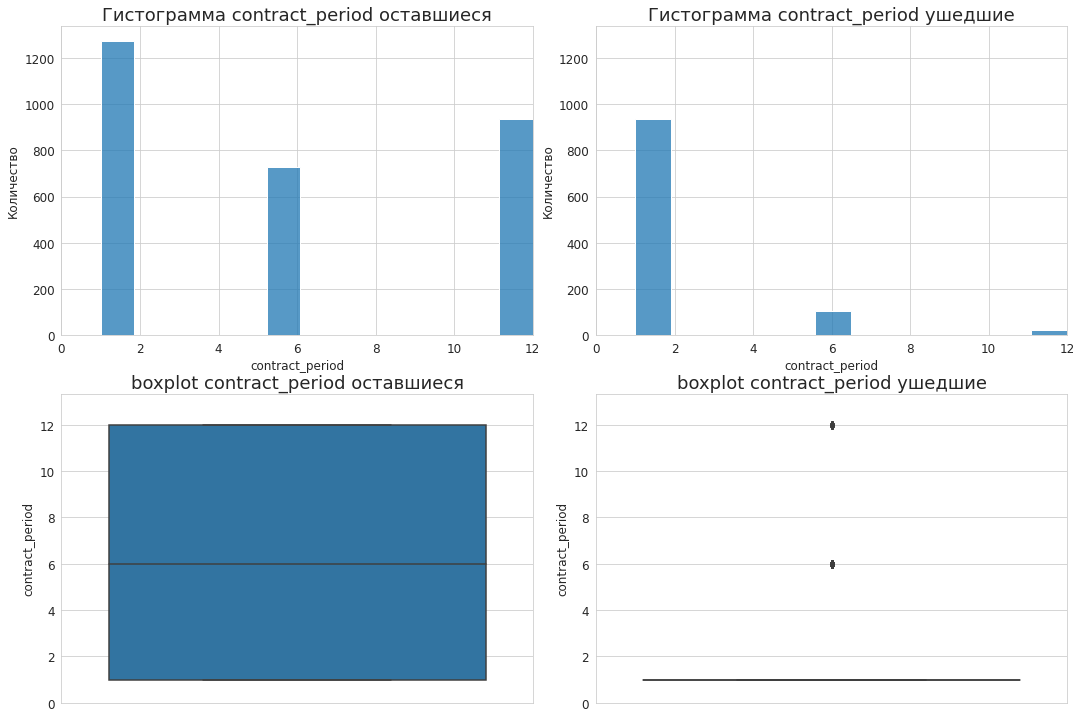

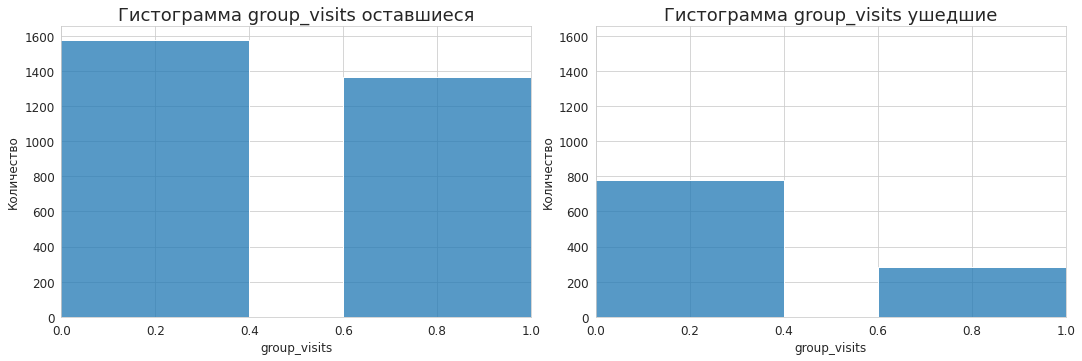

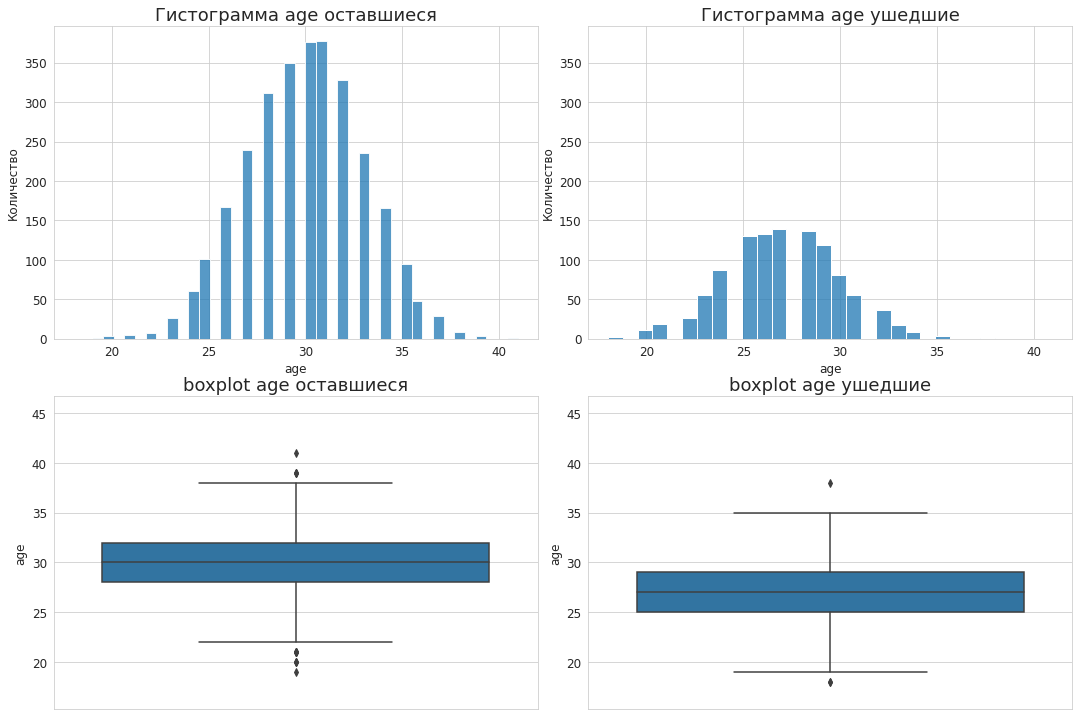

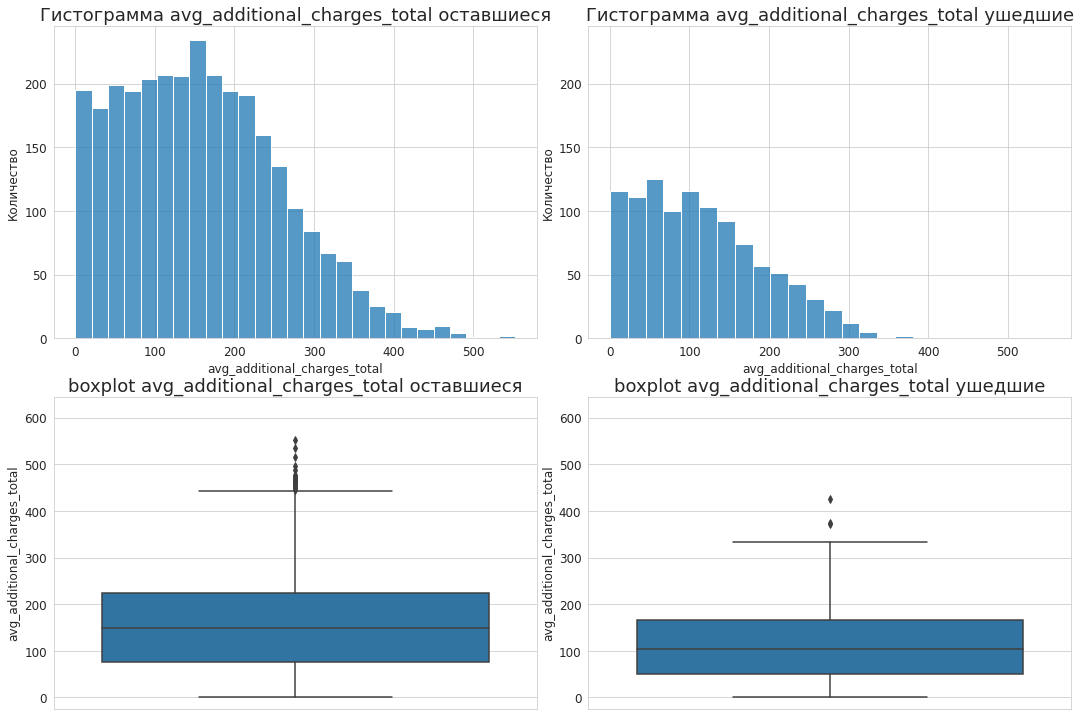

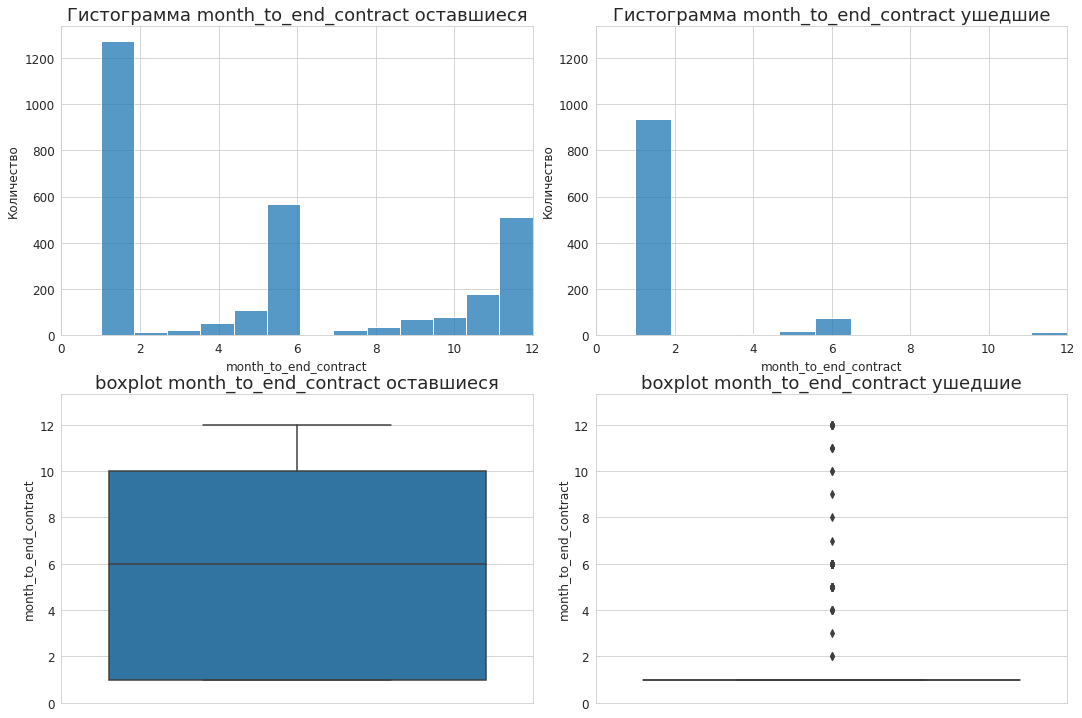

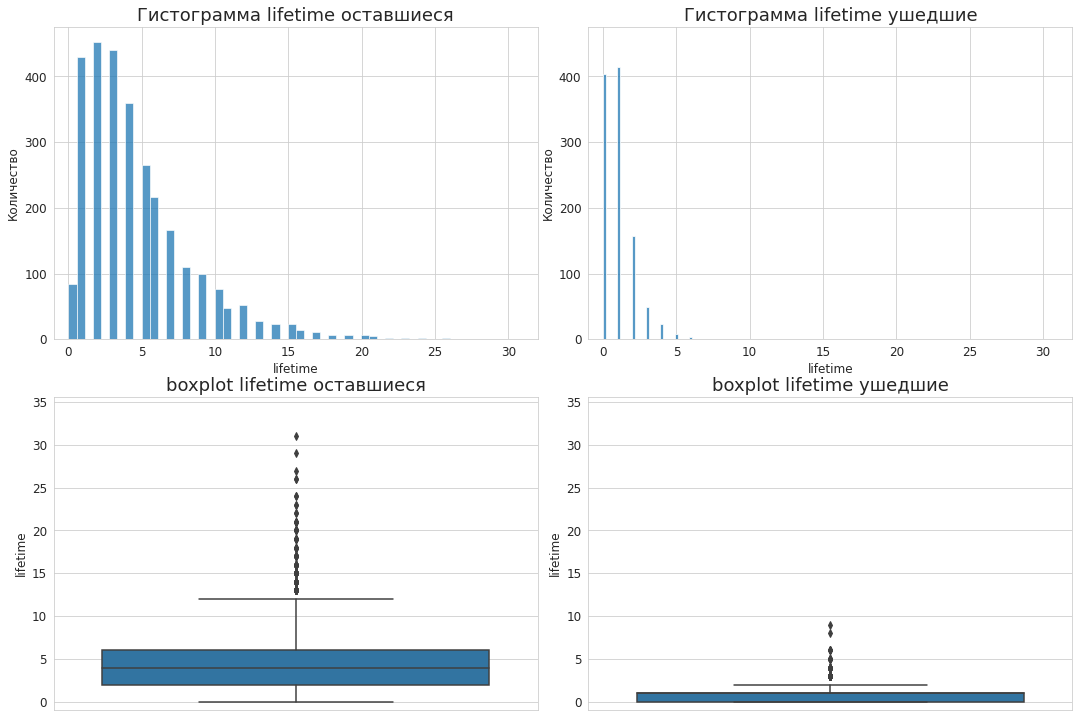

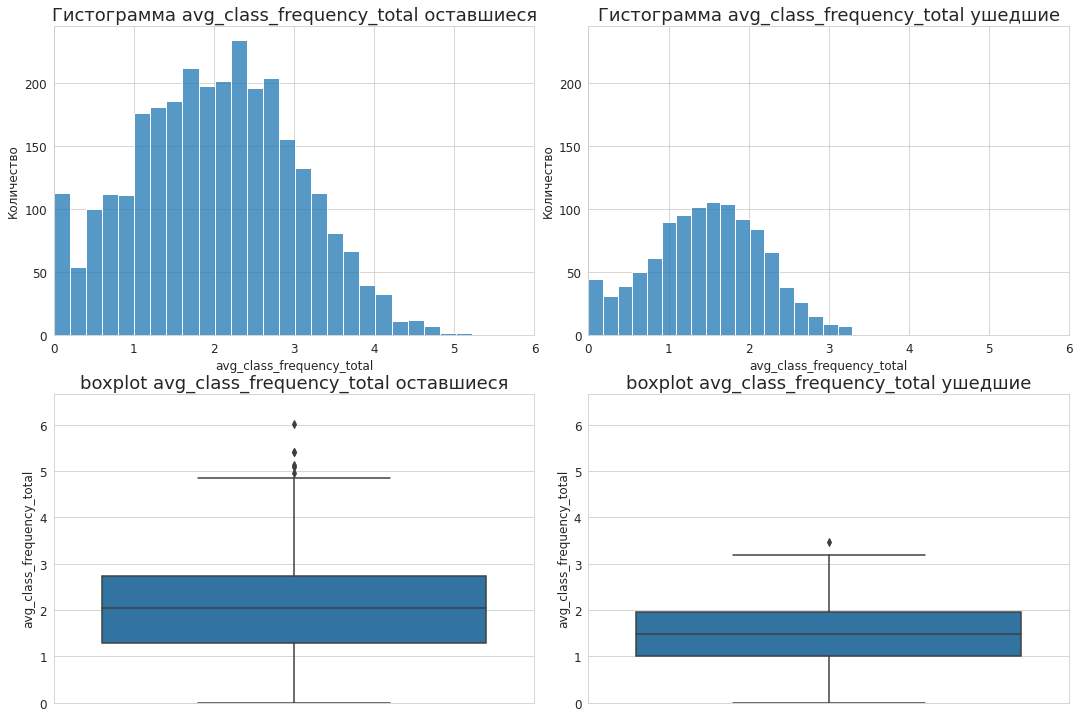

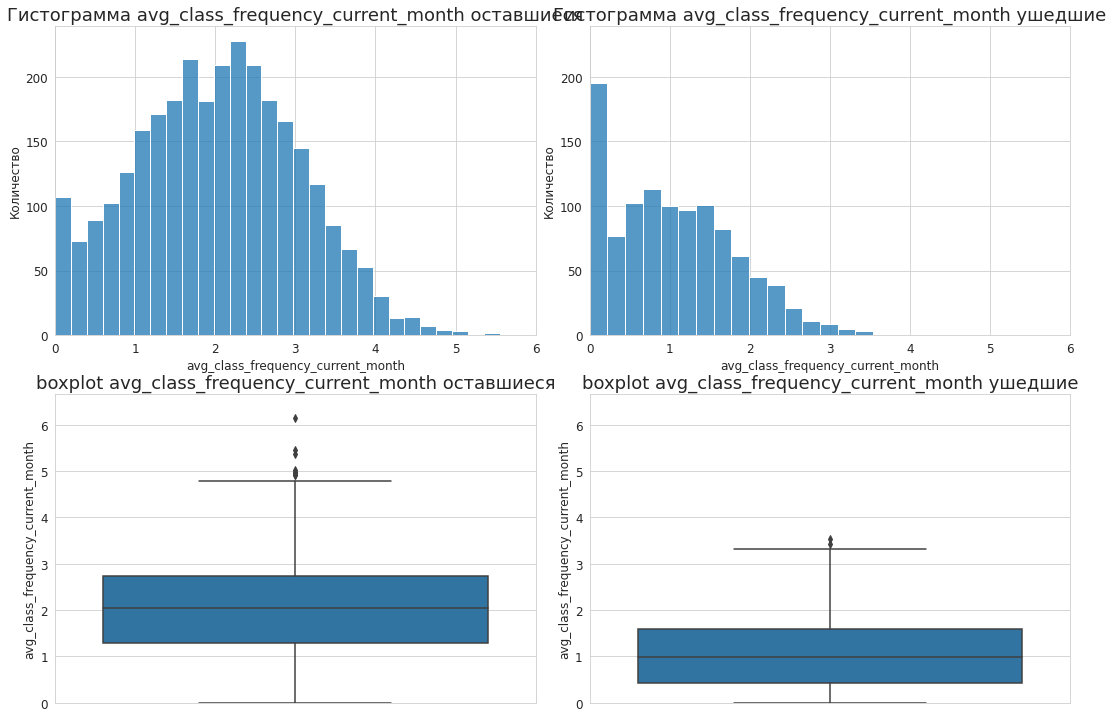

In [11]:
# визуализируем параметры
for column in df.drop(columns=['churn']).columns:
    draw_hist_bp(df, column)

Явных аномалий (выбросов) в данных нет.

**Ключевые различия между ушедшими и оставшимися клиентами:**
1) Связь с компанией-партнером
    * Среди ушедших клиентов реже встречаются сотрудники компаний-партнёров.
    * Оставшиеся клиенты чаще связаны с партнёрскими организациями.
2) Длительность абонемента (contract_period)
    * Большинство ушедших клиентов имели абонемент на 1 месяц.
    * Сроки в 6 и 12 месяцев среди ушедших встречаются редко.
    * У оставшихся клиентов распределение по длительности абонемента более равномерное.
3) Возраст клиентов
    * Ушедшие клиенты в среднем моложе: 27 лет против 30 лет у оставшихся.
4) Выручка
    * Средний доход от ушедших клиентов немного ниже, чем от оставшихся.
    * Среди ушедших меньше высоких платежей.
5) Срок действия абонемента
    * Ушедшие клиенты чаще имеют краткосрочные абонементы.
    * У оставшихся сроки окончания абонементов распределены равномернее.
6) Время оттока
    * Основная часть уходов происходит в первые два месяца.
    * После 5 месяцев посещения отток минимален.
7) Посещаемость
    * Ушедшие клиенты в среднем посещали центр реже (< 4 визитов).
    * В их последний месяц наблюдалось снижение активности.


Проверим корреляцию параметров

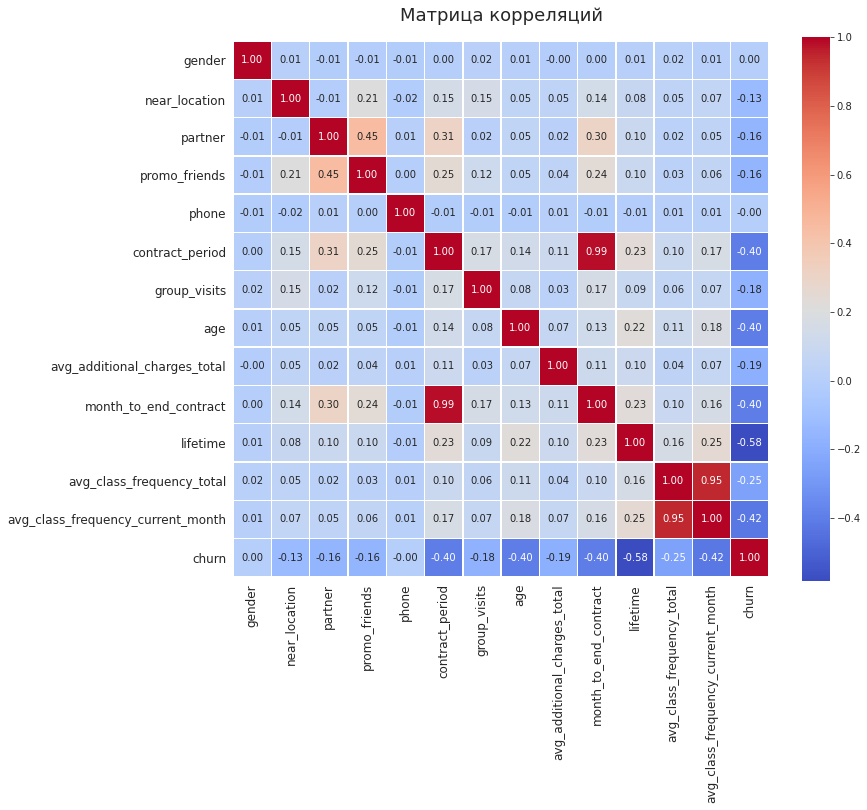

In [12]:
# вычисляем матрицу корреляций
# используем метод Спирмена т.к. присутствуют дискретные параметры
cm = df.corr(method='spearman') 
fig, ax = plt.subplots(figsize=(12, 10))

# строим тепловую карту
sns.heatmap(cm,
    annot=True,                # показывать значения в ячейках
    annot_kws={'size': 10},    # размер шрифта для аннотаций
    fmt=".2f",                # формат чисел 
    cmap='coolwarm',          # цветовая схема
    square=True,              # квадратные ячейки
    linewidths=0.5           # толщина линий между ячейками
            )

# Дополнительные улучшения:
plt.title('Матрица корреляций', pad=20, fontsize=18)  # заголовок с отступом
ax.tick_params(axis='both', labelsize=12)  # размер шрифта меток

plt.show()

Обнаружено две пары с большой корреляцией: `month_to_end_contract`-`contract_period` и `avg_class_frequency_current_month`-`avg_class_frequency_total` <br>

Заменим эти пары параметров их отношением

### Подготовка данных

#### Обработка сильно коррелирующих значений

In [13]:
# заменяем коррелирующие пары их отношением

# остаточная доля контракта
df['contract_portion_remains'] = df['month_to_end_contract']/df['contract_period'] 
# обрабатываем деление на 0
df['contract_portion_remains'] = df['contract_portion_remains'].replace(np.inf, 0) 

# рост/падение посещаемости
df['trend_frequency'] = df['avg_class_frequency_current_month']/df['avg_class_frequency_total'] 
# обрабатываем деление на 0
df['trend_frequency'] = df['trend_frequency'].replace(np.inf, 0) 

# проверка
df[['month_to_end_contract', 
    'contract_period', 
    'contract_portion_remains', 
    'avg_class_frequency_current_month',
    'avg_class_frequency_total',
    'trend_frequency'
       ]].sample(5)

,month_to_end_contract,contract_period,contract_portion_remains,avg_class_frequency_current_month,avg_class_frequency_total,trend_frequency
3069,11,12,0.916667,2.380177,2.453415,0.970148
3047,11,12,0.916667,2.412105,2.423806,0.995172
3520,6,6,1.000000,1.758146,1.809157,0.971804
926,12,12,1.000000,1.316054,1.165665,1.129016
29,5,6,0.833333,3.528886,3.511568,1.004932


In [14]:
# удаляем изначальные параметры
df = df.drop(columns=['month_to_end_contract',
                     'contract_period', 
                     'avg_class_frequency_current_month',
                     'avg_class_frequency_total'
                     ])

# переносим поле churn в конец для удобства
column_to_move = 'churn'
# собираем все столбцы кроме нужного, в конец добавляем нужный
new_order = [col for col in df if col != column_to_move] + [column_to_move]
df = df[new_order]

df.info() # проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        4000 non-null   int64  
 1   near_location                 4000 non-null   int64  
 2   partner                       4000 non-null   int64  
 3   promo_friends                 4000 non-null   int64  
 4   phone                         4000 non-null   int64  
 5   group_visits                  4000 non-null   int64  
 6   age                           4000 non-null   int64  
 7   avg_additional_charges_total  4000 non-null   float64
 8   lifetime                      4000 non-null   int64  
 9   contract_portion_remains      4000 non-null   float64
 10  trend_frequency               3941 non-null   float64
 11  churn                         4000 non-null   int64  
dtypes: float64(3), int64(9)
memory usage: 375.1 KB


В поле trend_frequency есть нулевые значения. Такое могло произойти в случае, когда числитель и делитель равен 0 (или бесконечности). Заменим все пропуски на 0.

In [15]:
# заменяем пропуски на 0
df['trend_frequency'] = df['trend_frequency'].fillna(0)

df.info() # проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        4000 non-null   int64  
 1   near_location                 4000 non-null   int64  
 2   partner                       4000 non-null   int64  
 3   promo_friends                 4000 non-null   int64  
 4   phone                         4000 non-null   int64  
 5   group_visits                  4000 non-null   int64  
 6   age                           4000 non-null   int64  
 7   avg_additional_charges_total  4000 non-null   float64
 8   lifetime                      4000 non-null   int64  
 9   contract_portion_remains      4000 non-null   float64
 10  trend_frequency               4000 non-null   float64
 11  churn                         4000 non-null   int64  
dtypes: float64(3), int64(9)
memory usage: 375.1 KB


Посторим еще раз матрицу корреляции с новыми параметрами

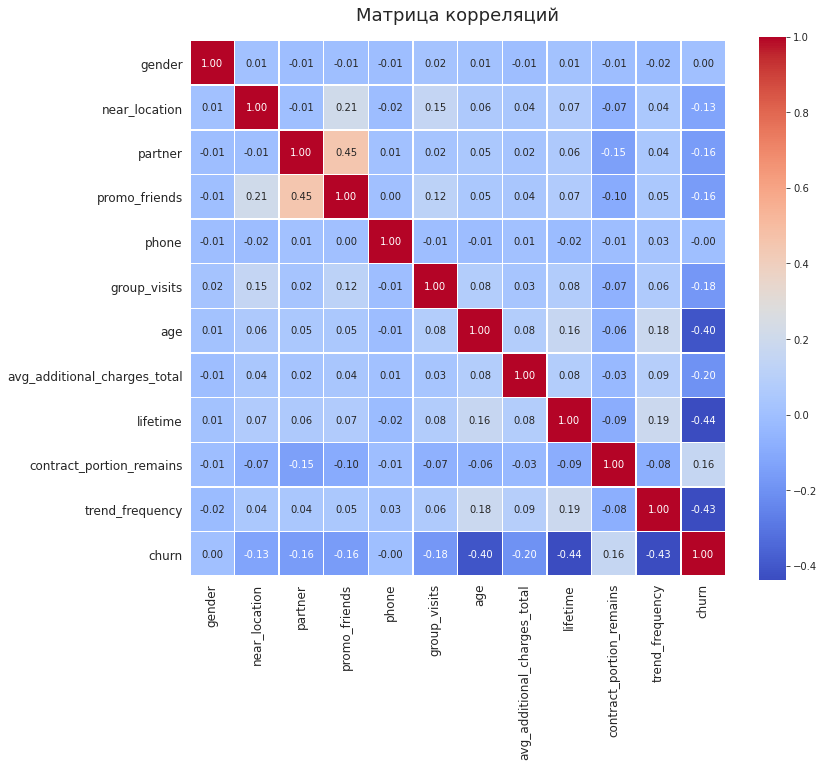

In [16]:
# вычисляем матрицу корреляций
cm = df.corr()
fig, ax = plt.subplots(figsize=(12, 10))

# строим тепловую карту
sns.heatmap(cm,
    annot=True,                # показывать значения в ячейках
    annot_kws={'size': 10},    # размер шрифта для аннотаций
    fmt=".2f",                # формат чисел 
    cmap='coolwarm',          # цветовая схема
    square=True,              # квадратные ячейки
    linewidths=0.5           # толщина линий между ячейками
            )

# Дополнительные улучшения:
plt.title('Матрица корреляций', pad=20, fontsize=18)  # заголовок с отступом
ax.tick_params(axis='both', labelsize=12)  # размер шрифта меток

plt.show()

Сильно коррелирующих параметров не осталось.

### Прогнозирования оттока клиентов

In [17]:
# разделяем данные на признаки и целевую переменную
X = df.drop('churn', axis=1)
y = df['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.2, random_state=12)

# стандартизируем данные
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

True # вывод выполнения ячейки

True

Обучим модель двумя способами и сравним результаты.

In [18]:
# обучаем модель методом логистической регрессии
logreg_model = LogisticRegression(random_state=12)
logreg_model.fit(X_train, y_train)

# предсказываем на валид. выборке
y_pred = logreg_model.predict(X_test)

# выводим точность модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность модели: {accuracy:.2f}')

# выводим отчета с метриками
class_report = classification_report(y_test, y_pred)
print('Отчет о классификации (лог.регрессия):\n', class_report)


Точность модели: 0.90
Отчет о классификации (лог.регрессия):
               precision    recall  f1-score   support

           0       0.92      0.95      0.93       586
           1       0.84      0.78      0.81       214

    accuracy                           0.90       800
   macro avg       0.88      0.86      0.87       800
weighted avg       0.90      0.90      0.90       800



In [19]:
# веса признаков (коэффициенты) (обязательна стандартизация)
print("Свободный член (intercept):", logreg_model.intercept_)
weights = logreg_model.coef_[0] # веса признаков

df_weight_logreg = pd.DataFrame(weights,
                    df.drop('churn', axis=1).columns
                        ).rename(
                            columns={0:'weight'})

df_weight_logreg.sort_values('weight') # вывод весов лог. регрессии

Свободный член (intercept): [-3.29975568]


,weight
lifetime,-3.829841
age,-1.047799
trend_frequency,-0.989631
avg_additional_charges_total,-0.573916
group_visits,-0.420963
partner,-0.290886
promo_friends,-0.263910
near_location,-0.144661
gender,-0.041545
phone,0.002367


Положительный вес - уменьшает вероятность попадания в класс "отток" <br>
Отрицательный вес - увеличивает вероятность попадания в класс "отток" 
<br><br>
Пример интрепретации: 
- При повышении значения lifetime уменьшается вероятность уйти в "отток".
- При повышении значения contract_portion_remains увеличивается вероятность уйти в "отток".
<br><br>
"Сила влияния" параметра определяется модулем значения.
<br><br>

PS: Вес параметра phone и gender низкий и влияния почти не оказывает.

Общая точность модели лог.регрессии составляет 90%. <br>
Точность определения попадания клиента в "отток" составляет 84%.<br><br>

Выполним прогноз методом "случайный лес" (ансамбль)

In [20]:
# обучаем модель методом случайного леса
random_forest_model = RandomForestClassifier(random_state=12)
random_forest_model.fit(X_train, y_train)

# предсказываем на валид. выборке
y_pred = random_forest_model.predict(X_test)

# выводим точность модели
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy:.2f}")

# выводим отчета с метриками
class_report = classification_report(y_test, y_pred)
print("Отчет по классификации (случайный лес):")
print(class_report)

Точность модели: 0.93
Отчет по классификации (случайный лес):
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       586
           1       0.90      0.84      0.87       214

    accuracy                           0.93       800
   macro avg       0.92      0.90      0.91       800
weighted avg       0.93      0.93      0.93       800



Общая точность модели "случайным лесом" составляет 93%. <br>
Точность определения попадания клиента в "отток" составляет 90%.

**Вывод по разделу:**
* Метод "случайный лес" демонстрирует более высокую точность прогнозирования на валидационных данных по сравнению с логистической регрессией.
* Общая точность (accuracy): 93% (у логистической регрессии — 90%).
* Precision для класса "отток": 90% (против 84% у логистической регрессии).
* Recall для класса "отток": 84% (против 78% у логистической регрессии).
<br><br>
Таким образом, "случайный лес" превосходит альтернативный метод по всем ключевым метрикам.

### Кластеризация клиентов

Определим типы клиентов по имеющимся данным

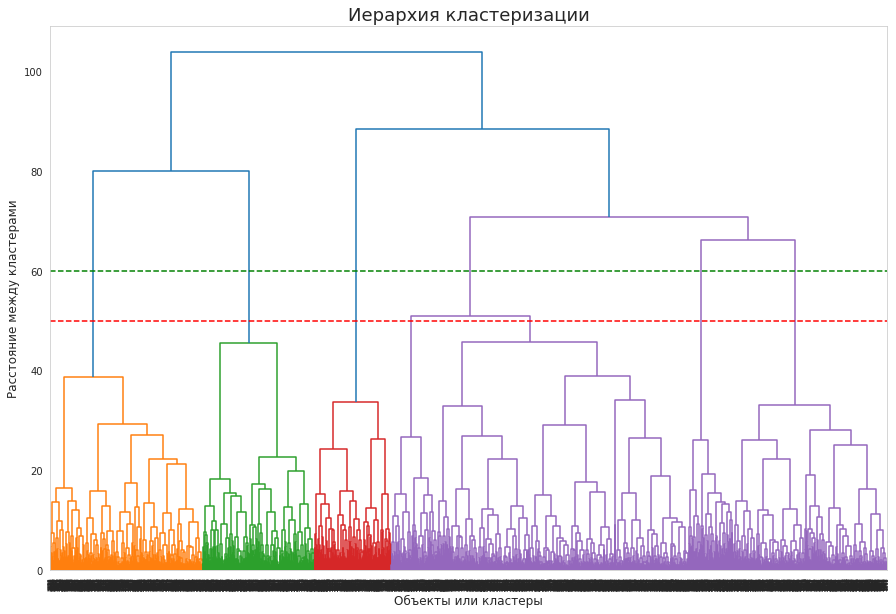

In [21]:
# проводим кластеризацию на основании всех данных
X = df

# стандартизация данных перед работой с алгоритмами (обязательно)
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# определяем матрицу расстояний
linked = linkage(X_sc, method = 'ward') 

# отображаем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.axhline(y=60, color='g', linestyle='--') # отметка на расстоянии 60
plt.axhline(y=50, color='r', linestyle='--') # отметка на расстоянии 50
plt.title('Иерархия кластеризации', fontsize=18)
plt.xlabel('Объекты или кластеры', fontsize=12)
plt.ylabel('Расстояние между кластерами', fontsize=12)
plt.grid()
plt.show() 

Анализ дендрограммы показывает, что оптимальное число кластеров лежит в диапазоне от 4 до 6. В качестве рабочего варианта предлагается выбрать 5 кластеров.

In [22]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=12)
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

# сохраняем метки кластера
df['cluster_km'] = labels

# сохраняем статистику по средним значениям признаков по кластерам
df_clusters_mean = df.groupby(by='cluster_km').mean()

df_clusters_mean # выводим результат

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,lifetime,contract_portion_remains,trend_frequency,churn
cluster_km,,,,,,,,,,,,
0,0.500898,0.000000,0.493716,0.080790,1.0,0.233393,28.815081,137.883325,3.104129,0.978755,0.869386,0.393178
1,0.506452,0.996774,0.852688,0.984946,1.0,0.545161,29.895699,157.451749,4.712903,0.929480,0.983178,0.016129
2,0.511396,1.000000,0.326923,0.000000,1.0,0.455840,30.034188,161.505104,4.665954,0.964447,0.999382,0.007123
3,0.513140,0.991701,0.329184,0.214385,1.0,0.286307,26.842324,113.590940,0.988935,0.992278,0.607057,0.987552
4,0.523316,0.862694,0.471503,0.305699,0.0,0.427461,29.297927,144.208179,3.940415,0.965674,0.867460,0.266839


Для удобства анализа данных отобразим heatmap с цветовой градуировкой по столбцам

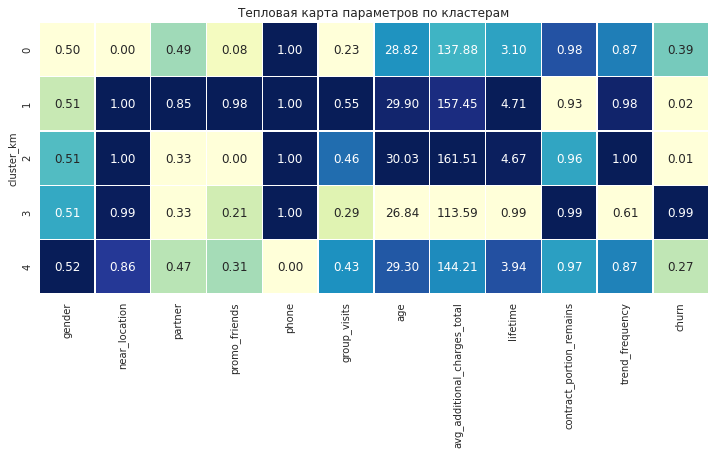

In [23]:
# нормализуем каждый столбец отдельно (для единого масштаба)
df_normalized = df_clusters_mean.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# строим heatmap с нормализацией по столбцам
plt.figure(figsize=(12, 5))
sns.heatmap(
    df_normalized,
    annot=df_clusters_mean,  # отображаем исходные значения
    fmt=".2f",              # формат чисел
    cmap='YlGnBu',         # цветовая схема
    linewidths=0.5,         # границы между ячейками
    annot_kws={"size": 12}, # размер текста
    cbar=False              # отключаем общую colorbar (так как нормализация по столбцам)
        )

plt.title("Тепловая карта параметров по кластерам")
plt.show()

* Оттока отсутствует в кластерах 1 и 2.
* Основной отток представлен кластером 3. Он характеризуется:
    - на высоком показателе contract_portition_remains (доля выполненного абонемента), 
    - на высоким показателе near_location (фитнес центр в районе проживания/работы),
    - на среднем показателе promo_friends (клиент воспользовался акцией "Приведи друга"),
    - на низком показателе group_visits (клиент посещал групповые занятия),
    - на низком показателе partner (сотрудник компании-партнёра клуба),
    - на самом низком показателе lifetime (время с первого обращения),
    - на самом низком показателе avg_additional_charges_total (суммарная выручка от других услуг фитнес-центра),
    - на самом низком показателе age (возраст),
    - на самом низком показателе trend_frequency (динамика изменения среднего количества посещений)
* Значимая доля оттока представлена кластером 0. Он характеризуется:
    - нулевым показателем near_location (фитнес центр в районе проживания/работы), единственный кластер с таким показателем,
    - на высоком показателе contract_portition_remains (доля выполненного абонемента), 
    - на среднем показателе partner (сотрудник компании-партнёра клуба),
    - на низком показателе age (возраст),
    - на низком показателе avg_additional_charges_total (суммарная выручка от других услуг фитнес-центра),
    - на низком показателе promo_friends (клиент воспользовался акцией "Приведи друга"),
    - на самом низком показателе group_visits (клиент посещал групповые занятия)
<br><br>

Остальные характеристики кластеров можно посмотреть на тепловой карте. <br> 
*Примечание: при анализе тепловой карты надо смотреть не только на цвет градиента, но и на числовое значение показателя. Например, параметр phone идентичен для всех кластеров.*

Отобразим распределение признаков для кластеров.

In [24]:
# иницилизируем функцию отрисовки столбчатого графика
# с указанием долей значений по кластерам
def draw_bars_part(data, field, cnt_category=5):
    """
    Функция создает визуализацию, показывающую долю каждой категории признака в разных кластерах.
    Для числовых признаков с большим количеством уникальных значений автоматически создаются категории.
    
    Параметры:
    ----------
    data : pandas.DataFrame
        Исходный DataFrame с данными, содержащий колонки 'cluster_km' и поле field
    field : str
        Название колонки в DataFrame, для которой строится распределение
        В поле должны быть числовые значения int или float
    cnt_category : int, optional (default=5)
        Количество категорий для группировки числовых признаков (если уникальных значений много)
        
    Возвращает:
    -----------
    None
        Функция только отображает график, не возвращает значений
    
    Пример использования:
    ---------------------
    draw_bars_part(df, 'age')  # Построение распределения возраста по кластерам
    """
    
    # создаем временный dataframe
    temp_df = pd.DataFrame({'cluster_km':data['cluster_km'], 
                            field:data[field]}, 
                           index=df.index)
    
    # перевод числовых значений в фиксированные категории 
    if temp_df[field].nunique() >= cnt_category: # если уник. значений больше заданого порога
        flag_low_value = temp_df[field].max()<10 # флаг низких пороговых значений
        # разделяем на равные по значению категории
        if flag_low_value: # если низкие значения
            # для малых значениях около 0 используем логарифмирования
            temp_df[field] = np.log1p(temp_df[field])
            # разделяем на равные по значению категории
            temp_df[field] = pd.cut(temp_df[field], bins=cnt_category)
            # создаем строковое представление категорий (для легенды)
            temp_df[field] = temp_df[field].transform(
                    lambda x: f'{np.expm1(x.left):.3f} - {np.expm1(x.right):.3f}') # с обр. преобразованием
        else: # если высокие значения
            # разделяем на равные по значению категории
            temp_df[field] = pd.cut(temp_df[field], bins=cnt_category)
            # создаем строковое представление категорий (для легенды)
            temp_df[field] = temp_df[field].transform(
                    lambda x: f'{int(x.left)+1} - {int(x.right)}')
    else:
        pass 
    
    # определяем доли для каждой категории по кластерам
    cluster_proportions = temp_df.groupby('cluster_km')[field].value_counts(normalize=True).unstack()
    
    
    # отображаем сток. столбчатый график с распределением по кластерам
    fig, ax = plt.subplots(figsize=(8, 4))
    cluster_proportions.plot(kind='bar', stacked=True, width=0.7, ax=ax)
    
    # добавление меток (с указанием значений доли свыше 5%)
    for number_cat, bars in enumerate(ax.containers): # проходимся по столбцам
        for p in bars: # получаем геометрические данные по категориям
            count_in_cat = p.get_height() # записываем в переменну количественное значение
            percent = count_in_cat*100 # записываем % (данные нормализованы)
            if percent > 5: # отображаем значениее больше 5%
                ax.annotate(f'{percent:.0f}%', # значение
                    (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()/2), # координаты x, y
                    ha='center', va='baseline', # точки центрирования
                    fontsize=10, color='black', # шрифт
                    xytext=(0, -3), textcoords='offset points' # смещение
                           )

    # параметры графика
    plt.xlabel('Кластер №')
    plt.ylabel('Доля (%)')
    plt.title(f'Распределение признака {field} по кластерам')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left') # легенду за пределы отрисовки
    # меняем долевое отображение оси на процентное
    yticks_labels = [f'{int(y*100)}%' for y in plt.yticks()[0][:-1]]
    plt.yticks(plt.yticks()[0][:-1], yticks_labels)
    
    plt.show()
        
True # проверка выполнения ячейки

True

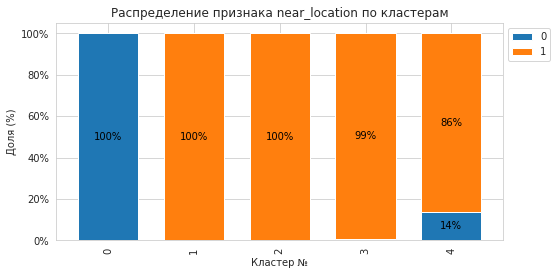

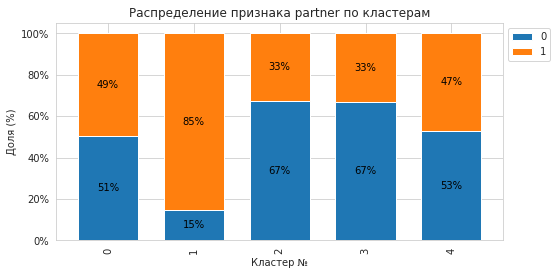

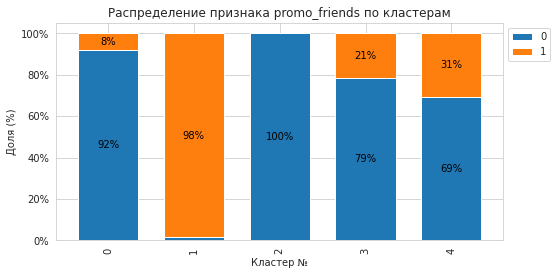

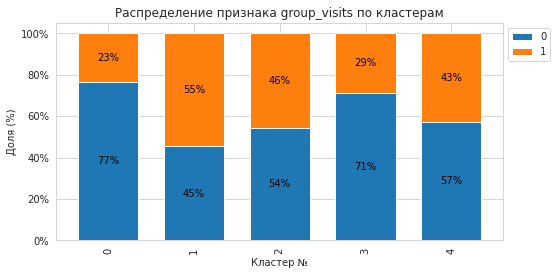

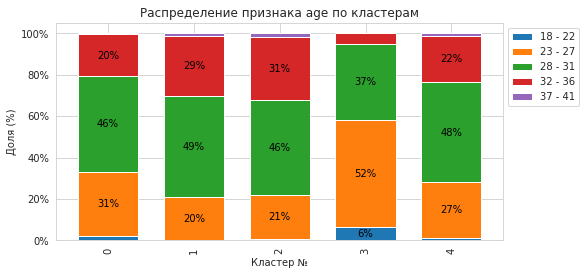

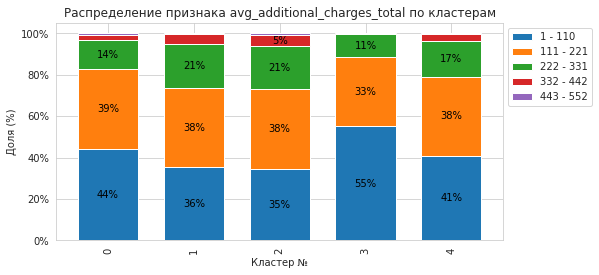

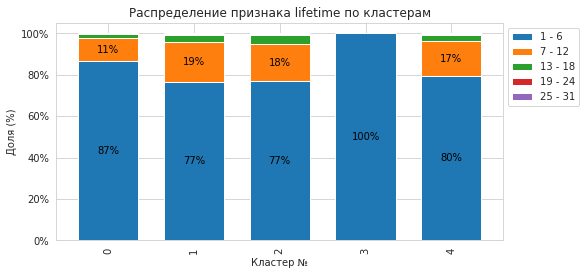

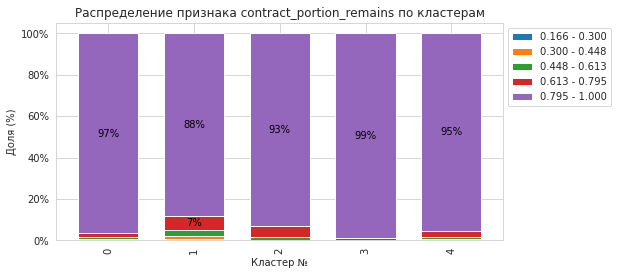

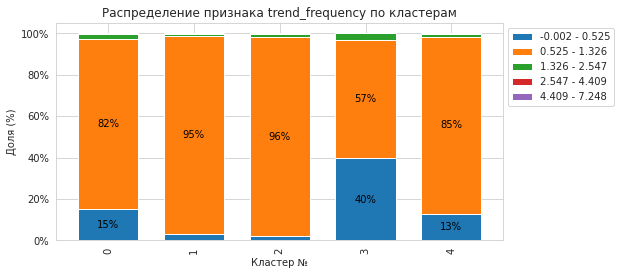

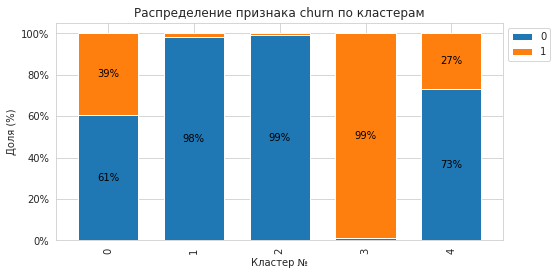

In [25]:
# визуализируем распределение параметров

# исключаем неинформативные столбцы
drops_columns = ['cluster_km', 'gender', 'phone'] 

for column in df.drop(drops_columns, axis=1).columns:
    draw_bars_part(df, column)

### Общий вывод

**Обработка данных:**
* Пропусков в исходных данных не обнаружено
* Дубликатов в исходных данных не обнаружено
* Обнаружено две пары с большой корреляцией: `month_to_end_contract`-`contract_period` и `avg_class_frequency_current_month`-`avg_class_frequency_total`. Эти пары были заменены их отношением:
    - contract_portion_remains - доля выполненного абонемента (month_to_end_contract/contract_period)
    - trend_frequency - динамика изменения среднего количества посещений (avg_class_frequency_current_month/avg_class_frequency_total)

**Исследовательский анализ данных:** <br><br>

Общий отток клиентов составляет 26,5% <br>

В ходе исследовательского анализа данных были выявлены ключевые различия между ушедшими и оставшимися клиентами:
1. Связь с компанией-партнером
    * Ушедшие клиенты реже являются сотрудниками компаний-партнёров.
    * Среди оставшихся клиентов доля связанных с партнёрскими организациями выше.
2. Длительность абонемента
    * Большинство ушедших клиентов пользовались краткосрочными абонементами (1 месяц).
    * Долгосрочные абонементы (6 и 12 месяцев) среди ушедших встречаются редко.
    * У оставшихся клиентов распределение по срокам абонемента более сбалансированное.
3. Возраст клиентов
    * Средний возраст ушедших клиентов ниже (27 лет против 30 лет у оставшихся).
4. Выручка
    * Средний доход от ушедших клиентов несколько ниже.
    * Среди них реже встречаются высокие платежи.
5. Срок действия абонемента
    * Ушедшие клиенты чаще выбирали краткосрочные абонементы.
    * У оставшихся сроки окончания абонементов распределены равномерно.
6. Динамика оттока
    * Основная часть уходов происходит в первые два месяца взаимодействия.
    * После 5 месяцев посещения отток становится минимальным.
7. Посещаемость
    * Ушедшие клиенты в среднем посещали центр реже (< 4 визитов).
    * В последний месяц перед уходом их активность снижалась.
8. Незначимые факторы
    * Пол клиента (gender) и наличие телефона (phone) не оказывают существенного влияния на отток.

<br><br>
Наиболее значимыми факторами, влияющими на отток клиентов, согласно исследовательскому анализу, являются длительность абонемента, возраст, посещаемость и связь с партнёрскими организациями.

**Прогнозирование оттока клиентов:** <br><br>

В ходе построения модели машинного обучения для прогнозирования оттока клиентов были получены следующие результаты:
* Сравнение моделей:
    - Алгоритм "Случайный лес" показал более высокую эффективность по сравнению с логистической регрессией по всем ключевым метрикам:
        * Accuracy (общая точность): 93% (против 90% у логистической регрессии).
        * Precision (точность для класса "отток"): 90% (против 84%).
        * Recall (полнота для класса "отток"): 84% (против 78%).
        * Таким образом, "Случайный лес" обеспечивает более надежное прогнозирование оттока с точностью 93% и лучше выявляет клиентов, склонных к уходу.
* Ключевые факторы оттока (по логистической регрессии):
    - Наибольшее влияние на вероятность оттока оказывают следующие параметры (с отрицательными весами, что означает их обратную зависимость с оттоком):
        1. Lifetime (–3.83) – чем дольше клиент остается, тем ниже вероятность ухода.
        2. Age (–1.05) – более взрослые клиенты менее склонны к оттоку.
        3. Trend_frequency (–0.99) – снижение частоты посещений увеличивает риск оттока.
        4. Avg_additional_charges_total (–0.57) – клиенты с меньшими дополнительными расходами чаще уходят.
        5. Group_visits (–0.42) – посещение групповых занятий снижает вероятность оттока.
        
<br><br>
Для прогнозирования оттока клиентов рекомендуется использовать модель "Случайный лес", демонстрирующую наилучшие показатели.


**Кластеризация клиентов:** <br><br>

Анализом дендрограммы выделили 5 кластеров клиентов.

1. Безопасные кластеры (1, 2):
* Не демонстрируют признаков оттока
* Представляют стабильную клиентскую базу
2. Кластер максимального риска (3):
* Отличительные особенности:
  - Максимальный показатель завершенности абонемента (contract_portion_remains)
  - Удобное расположение клуба (near_location)
  - Молодой возраст
  - Краткий срок взаимодействия (минимальный lifetime)
  - Низкая вовлеченность: редкие посещения, минимальные дополнительные расходы, слабая динамика посещаемости
3. Кластеры умеренного риска (0, 4):
* Отличительные особенности:
  - Некомфортное расположение клуба (единственный кластер(0) с near_location=0)
  - Высокая степень завершенности абонемента (contract_portion_remains)
  - Молодой возраст
  - Минимальная вовлеченность в групповые занятия
  - Низкие дополнительные расходы

<br> <br>
Характеристики кластеров можно посмотреть на тепловой карте. <br> 
*Примечание: при анализе тепловой карты надо смотреть не только на цвет градиента, но и на числовое значение показателя. Например, параметр phone идентичен для всех кластеров.*
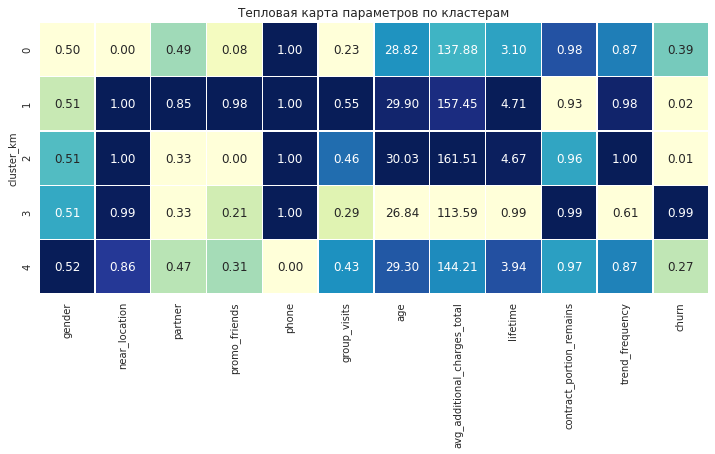


### Рекомендации

**Рекомендации по привлечению и удержанию клиентов:**
<br><br>
На основе проведенного анализа можно сформулировать следующие стратегические направления для работы с клиентской базой:
<br>
1) Привлечение новых клиентов:
   - Акцент на социальную вовлеченность:
   - Развивать партнерские программы с корпоративными клиентами.
   - Активно продвигать акцию "Приведи друга" с бонусами для участников.
<br><br>


2) Снижение оттока:
   - Поддерживать текущий показатель оттока на уровне 26,5%, не допуская его роста.
   - Регулярно оценивать вероятность ухода клиентов с помощью обученной модели "Случайный лес" и следить за точностью прогнозов. По необходимости надо дообучать модель на новых данных.
   - Делать акцент на социальном взаимодействии. Привлекать клиентов на участие в групповых занятиях, участие в локальных мероприятиях.
   - Стимулирование долгосрочных абонементов:
       * Делать маркетинговый упор на выгоду 6 и 12-месячных абонементов (скидки, дополнительные услуги).
       * Для новых клиентов (до 3х месяцев) предлагать дополнительные скидки и "бонусы".
       * Внедрять гибкие условия для перехода с краткосрочных на долгосрочные программы.
    <br>   <br>
    
    
3) Работа с проблемными сегментами:
   - Для молодой аудитории (до 30 лет), склонной к оттоку:
       * Разработать программы адаптации (бесплатные пробные занятия, персональные консультации).
       * Усилить информированность о пользе групповых занятий и дополнительных услуг.